In [1]:
import pandas as pd
import numpy as np
import re
import itertools as it
import os
from scipy.stats import norm, chi2

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 6, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages

# import warnings

# # Suppress all warnings
# warnings.filterwarnings('ignore')

In [2]:
PROJECT_DIR = "/Users/deeprobanerjee/Documents/bmi_project/BMI_monogenic"

In [3]:
filename = os.path.join(PROJECT_DIR, "data/meta/results/all_ancestry/ivw_fixed/bmi_rint_monogenic_meta.tsv")
sig_meta_res_df = pd.read_csv(filename, sep="\t")

In [4]:
def get_most_deleterious_idx(ser):
    all_masks = set(ser.unique())
    most_del = "Missense_lenient"
    if "pLoF" in all_masks:
        most_del = "pLoF"
    elif "Missense_strict" in all_masks:
        most_del = "Missense_strict"
    most_del_idx = ser.loc[ser==most_del].index[0]
    return most_del_idx


In [5]:
most_del_sig_meta_df = sig_meta_res_df.loc[sig_meta_res_df.groupby("gene")["gene_mask"].apply(get_most_deleterious_idx)].sort_values("p_value").reset_index(drop=True)

In [6]:
def calculate_heterogeneity_p_value(effect_sizes, standard_errors):
    """
    Calculate Cochran's Q statistic and p-value for heterogeneity.

    Parameters:
    - effect_sizes (list or np.array): Effect sizes from studies.
    - standard_errors (list or np.array): Standard errors of the effect sizes.

    Returns:
    - Q (float): Cochran's Q statistic.
    - p_value (float): P-value for heterogeneity.
    """
    # Convert inputs to numpy arrays
    effect_sizes = np.array(effect_sizes)
    standard_errors = np.array(standard_errors)
    
    # Calculate weights (inverse of variance)
    weights = 1 / standard_errors**2
    
    # Weighted mean effect size
    weighted_mean = np.sum(weights * effect_sizes) / np.sum(weights)
    
    # Calculate Q statistic
    Q = np.sum(weights * (effect_sizes - weighted_mean)**2)
    
    # Degrees of freedom
    df = len(effect_sizes) - 1
    
    # Calculate p-value using chi-squared distribution
    p_value = 1 - chi2.cdf(Q, df)
    
    return Q, p_value


def calculate_eur_noneur_p_value_het(ser):
    q_stat, p_hetz = calculate_heterogeneity_p_value([ser.ebeta, ser.nebeta], [ser.ese, ser.nese])
    return pd.Series({"gene": ser.gene, "gene_mask": ser.gene_mask, "q_stat": q_stat, "p_hetz": p_hetz})


In [7]:
p_het_df = most_del_sig_meta_df.apply(calculate_eur_noneur_p_value_het, axis=1)
p_het_dict = dict(zip(p_het_df.gene, p_het_df.p_hetz))


In [8]:
p_het_df.to_csv(os.path.join(PROJECT_DIR, "data/meta/tables/qstats_ancestry.tsv"), sep="\t", index=False)

# Get per ancestry files for these genes and their corresponsing mask

In [8]:
def calculate_ci(ser, alpha=0.05):
    # Calculate critical value for confidence interval
    z_critical = norm.ppf(1 - alpha / 2) 

    # Calculate confidence interval bounds
    lower_ci = ser.BETA - z_critical * ser.SE
    upper_ci = ser.BETA + z_critical * ser.SE
    return pd.Series({"ci_low": lower_ci, "ci_high": upper_ci})


def get_anc_stats(sig_df, anc_df):
    sig_merge_cols = ["gene", "gene_mask"]
    anc_merge_cols = ["hgnc_gene", "gene_mask"]
    anc_stats_cols = ["BETA", "SE", "p_value", "nsamples"]
    merged_df = sig_df.loc[:, sig_merge_cols].merge(anc_df.loc[:, anc_merge_cols + anc_stats_cols], left_on=sig_merge_cols, right_on=anc_merge_cols)
    merged_df[["ci_low", "ci_high"]] = merged_df.apply(calculate_ci, axis=1)
    return merged_df.rename(columns={"BETA": "beta", "SE": "se"}).drop(columns=["hgnc_gene"]).set_index(["gene", "gene_mask"])


def p_value_formatter(pval):
    if pval==0:
        pval = "0"
    else:
        pval = f"{pval:.2e}"
        pval = pval.replace("e", "x10")
    return pval


# Plotting

In [9]:
long_plot_df = pd.DataFrame()

# Add meta statistics to long format
plot_df = most_del_sig_meta_df.copy()
plot_df = plot_df.set_index(["gene", "gene_mask"])
plot_df = plot_df.rename(columns={"esamples": "ensamples", "nesamples": "nensamples"})
plot_columns = [c for c in plot_df.columns if c!="gene"]

meta_analysis = ["", "e", "ne"]
meta_category = ["meta", "eur_meta", "non_eur_meta"]
anc_category = ["All-ancestry", "European", "Non-european"]
stats_cols = ["beta", "se", "ci_low", "ci_high", "p_value", "nsamples"]

for m,c,ac in zip(meta_analysis, meta_category, anc_category):
    pdf = plot_df.loc[:, [f"{m}{s}" for s in stats_cols]]
    pdf.columns = stats_cols
    pdf["category"] = c
    pdf["anc_category"] = ac
    long_plot_df = pd.concat((long_plot_df, pdf))


# Add ancestry wise statistics to long format
ancestry = ["afr", "amr", "eas", "eur", "mid", "sas"]
anc_category = ["Non-european", "Non-european", "Non-european", "European", "Non-european", "Non-european"]
biobank = ["ukb", "aou"]
anc_dir = os.path.join(PROJECT_DIR, "data/meta/processed/all_ancestry/")


for a,ac in zip(ancestry, anc_category):
    for b in biobank:
        anc_file = os.path.join(anc_dir, f"bmi_rint_{a}_{b}.tsv.gz")
        anc_df = pd.read_csv(anc_file, sep="\t")
        merged_anc_df = get_anc_stats(most_del_sig_meta_df, anc_df)
        merged_anc_df["category"] = f"{a}_{b}"
        merged_anc_df["anc_category"] = ac
        long_plot_df = pd.concat((long_plot_df, merged_anc_df))


long_plot_df = long_plot_df.reset_index()
long_plot_df["formatted_beta"] = long_plot_df.beta.apply(lambda x: f"{x:.2f}")
long_plot_df["formatted_ci"] = "(" + long_plot_df.ci_low.apply(lambda x: f"{x:.2f}") + ", " + long_plot_df.ci_high.apply(lambda x: f"{x:.2f}") + ")"
long_plot_df["formatted_se"] = long_plot_df.se.apply(lambda x: f"{x:.2f}")
long_plot_df["formatted_p_value"] = long_plot_df.p_value.apply(p_value_formatter)
long_plot_df["Beta (95% CI)"] = long_plot_df.apply(lambda ser: f"{ser.formatted_beta} {ser.formatted_ci}", axis=1)


In [10]:
def create_forestplot(
    df, studies, category_order, 
    labels_col, category_col, effect_sizes_col, ci_low_col, ci_high_col,
    stats_cols, study_label, p_het_dict
):
    # Define markers for each category
    markers = dict(it.zip_longest(category_order, "osD", fillvalue="o"))
    # Define colors for each category
    palette = ["royalblue", "indianred", "gray"] # ["lightgrey", "darkgrey", "black"]

    colors = dict(it.zip_longest(category_order, palette, fillvalue="black"))

    # Create a figure with two axes
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(5, 3), gridspec_kw={'width_ratios': [2, 1.5]},sharey=True)

    # Horizontal line at 0 for the null effect
    ax.axvline(x=0, color='k', linestyle='--', lw=1)
    
    df["ci_low_error"] = df[effect_sizes_col] - df[ci_low_col]
    df["ci_high_error"] =  df[ci_high_col] - df[effect_sizes_col]
    
    ### main plot ###
    HEADER_COL_POS=-0.5
    # Plotting the effect sizes with different markers per category
    last_offset = 0
    last_offset_inc = 0.5
    ioffset_inc = 0.5
    for j,category in enumerate(category_order):
        cat_df = df.loc[df[category_col]==category]
        ax.text(min(df[ci_low_col])-0.75, last_offset, category, ha='center', va='center', fontweight='normal')
        last_offset += last_offset_inc
        ioffset=0
        for i, study in enumerate(studies):
            if len(cat_df.loc[(cat_df[labels_col]==study), effect_sizes_col])>0:
                effect_size = cat_df.loc[(cat_df[labels_col]==study), effect_sizes_col].values[0]
                ci_low_error = cat_df.loc[(cat_df[labels_col]==study), "ci_low_error"].values[0]
                ci_high_error = cat_df.loc[(cat_df[labels_col]==study), "ci_high_error"].values[0]
                errors = np.array([ci_low_error, ci_high_error]).reshape(2, 1)
                # Plot each category with a different marker
                ax.errorbar(
                    effect_size, ioffset+last_offset, xerr=[[ci_low_error], [ci_high_error]], 
                    fmt=markers[category], color=colors[category], capsize=2.5, elinewidth=1, ms=3.5
                    )
                # Place the study name above the group of categories
                ax.text(min(df[ci_low_col])-0.75, ioffset+last_offset, study, ha='center', va='center', fontweight='normal')
                ioffset+=ioffset_inc
        last_offset = ioffset+last_offset+0.25
        
    ax.text(
        min(df[ci_low_col])-0.75, HEADER_COL_POS, 
        f"{study_label}: p-heterogeneity={round(p_het_dict[study_label], 3)}", 
        ha='left', va='center', fontweight='normal', style="italic"
        )
    
    # Invert the y-axis so the studies are from top to bottom
    ax.invert_yaxis()

    # Customize the left axis: remove yticks but keep the ytick labels for study names
    ax.set_yticks([])
    # ax.set_xlim(-1.5,2.5)
    ax.tick_params(axis='y', which='both', length=0) 


    # Labels for axes
    ax.set_xlabel('Effect Size')
    # ax.set_title('Forest Plot')
    # Remove top, right, and left spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    last_offset = 0
    WRITE_HEADER_COUNT=0
    for j,category in enumerate(category_order):
        cat_df = df.loc[df[category_col]==category]
        last_offset +=last_offset_inc
        ioffset=0
        for i, study in enumerate(studies):
            if len(cat_df.loc[(cat_df[labels_col]==study), effect_sizes_col])>0:
                for s, st_col in enumerate(stats_cols):
                    stat = cat_df.loc[(cat_df[labels_col]==study), st_col].values[0]
                    ax2.text(0.25+0.75*s,ioffset+last_offset, f"{stat}", va='center', ha="center")
                    if WRITE_HEADER_COUNT<len(stats_cols):
                        ax2.text(0.25+0.75*s, HEADER_COL_POS, f"{st_col.lstrip('formatted_')}", va='center', ha="center")
                        WRITE_HEADER_COUNT+=1
                ioffset+=ioffset_inc
        last_offset = ioffset+last_offset+0.25

    # Remove the spines and ticks for ax2
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    # ax2.set_title('Statistics')

    plt.tight_layout()
    return fig


In [11]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_70270/222123636.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ci_low_error"] = df[effect_sizes_col] - df[ci_low_col]
/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_70270/222123636.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ci_high_error"] =  df[ci_high_col] - df[effect_sizes_col]
/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_70270/222123636.py:19: SettingWithCopyWarning: 
A value is trying to be set 

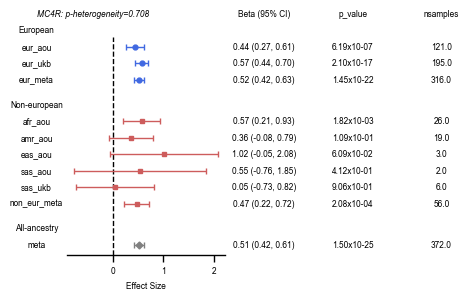

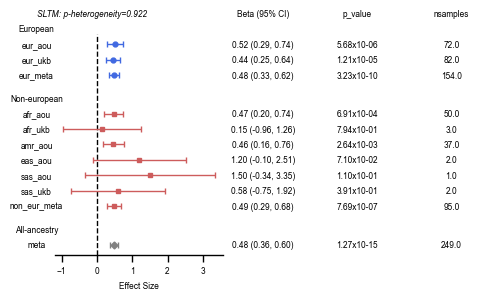

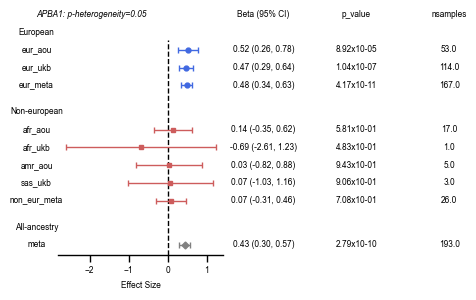

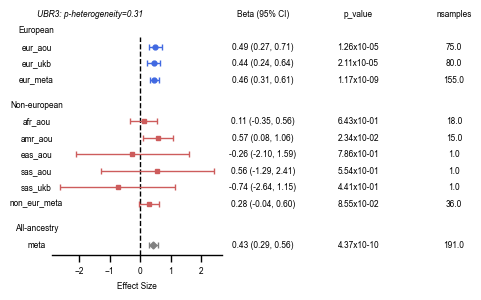

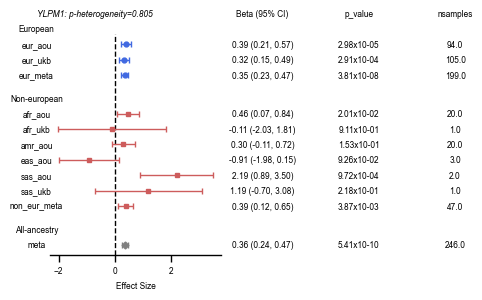

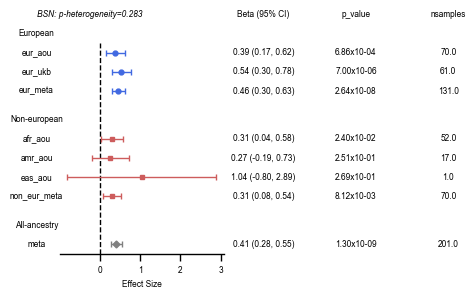

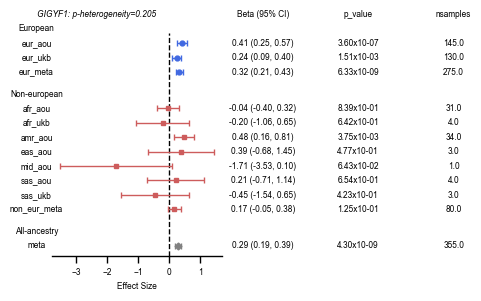

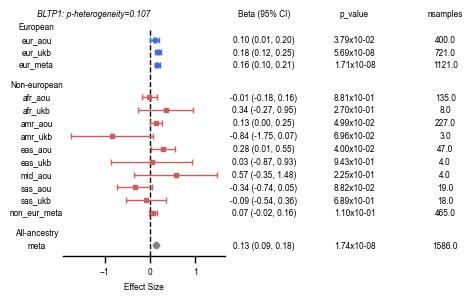

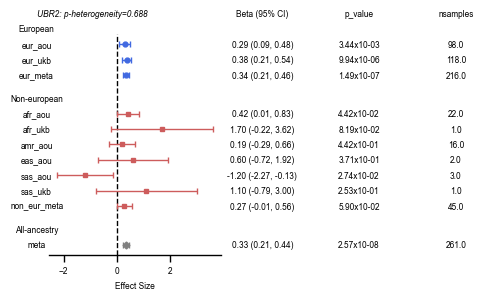

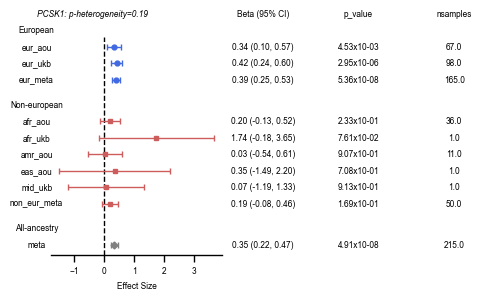

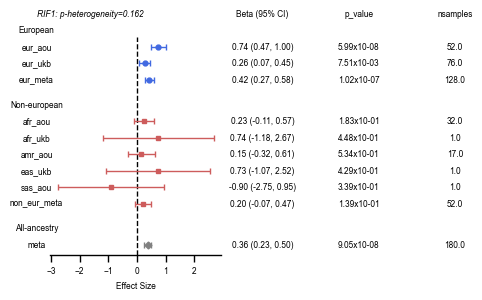

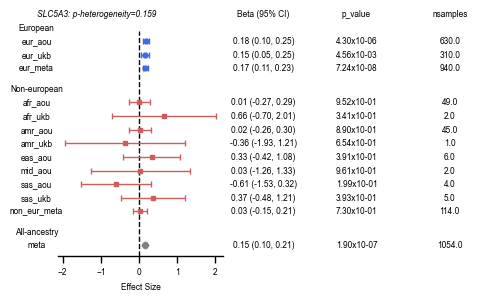

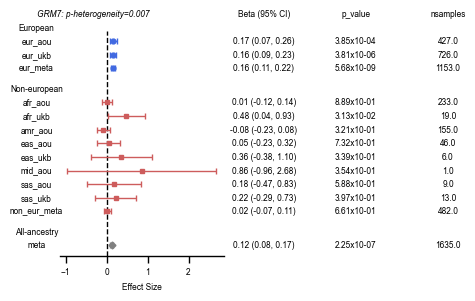

In [12]:
for gene in long_plot_df.gene.unique():
    gene_plot_df = long_plot_df.loc[long_plot_df.gene==gene]
    fig = create_forestplot(
        gene_plot_df, 
        ["eur_aou", "eur_ukb", "eur_meta", "afr_aou", "afr_ukb", "amr_aou", "amr_ukb", "eas_aou", "eas_ukb", "mid_aou", "mid_ukb", "sas_aou", "sas_ukb", "non_eur_meta", "meta"], 
        ["European", "Non-european", "All-ancestry"],
        labels_col="category", category_col="anc_category", 
        effect_sizes_col="beta", ci_low_col="ci_low", ci_high_col="ci_high",
        stats_cols=["Beta (95% CI)", "formatted_p_value", "nsamples"], 
        study_label=gene, p_het_dict=p_het_dict
    )
    filename = os.path.join(PROJECT_DIR, f"data/meta/figures/all_ancestry_forestplot_{gene}.pdf")
    save_pdf(filename, fig)
